In [25]:
from os import environ

environ['optimizer'] = 'Adam'
environ['num_workers']= '2'
environ['batch_size']= str(1024)
environ['n_epochs']= '500'
environ['batch_norm']= 'True'
environ['loss_func']='MSE'
environ['layers'] = '700 600 350 200 180'
environ['dropouts'] = '0.5 '*5
environ['log'] = 'True'
environ['weight_decay'] = '0.01'
environ['cuda_device'] ='cuda:1'
environ['dataset'] = 'data/speedup_dataset2.pkl'

%run utils.ipynb

In [26]:
train_dl, val_dl, test_dl = train_dev_split(dataset, batch_size, num_workers, log=log)

db = fai.basic_data.DataBunch(train_dl, val_dl, test_dl, device=device)

In [27]:
input_size = train_dl.dataset.X.shape[1]
output_size = train_dl.dataset.Y.shape[1]


model = None 

if batch_norm:
    model = Model_BN(input_size, output_size, hidden_sizes=layers_sizes, drops=drops)
else:
    model = Model(input_size, output_size)
    
if loss_func == 'MSE':
    criterion = nn.MSELoss()
else:
    criterion = mape_criterion

l = fai.Learner(db, model, loss_func=criterion, metrics=[mape_criterion, rmse_criterion])

if optimizer == 'SGD':
    l.opt_func = optim.SGD

In [167]:
l = l.load(f"speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}")

In [4]:
l.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


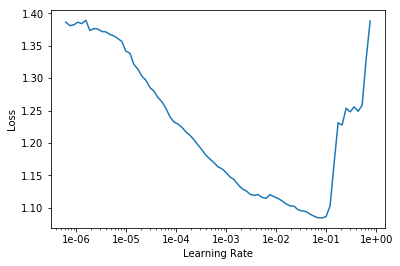

In [5]:
l.recorder.plot()

In [28]:
lr = 5e-4

In [29]:
l.fit_one_cycle(500, lr)

epoch,train_loss,valid_loss,mape_criterion,rmse_criterion
1,1.602632,1.127282,53.278530,1.061517
2,1.508404,1.131860,54.218723,1.063778
3,1.437943,1.117482,51.343048,1.056950
4,1.401399,1.104737,48.619419,1.050963
5,1.319258,1.097302,47.089104,1.047386
6,1.290876,1.084988,44.126720,1.041338
7,1.314273,1.088543,45.117569,1.043242
8,1.276925,1.091102,45.884914,1.044423
9,1.242279,1.089023,45.397400,1.043486
10,1.226257,1.089691,45.627354,1.043703


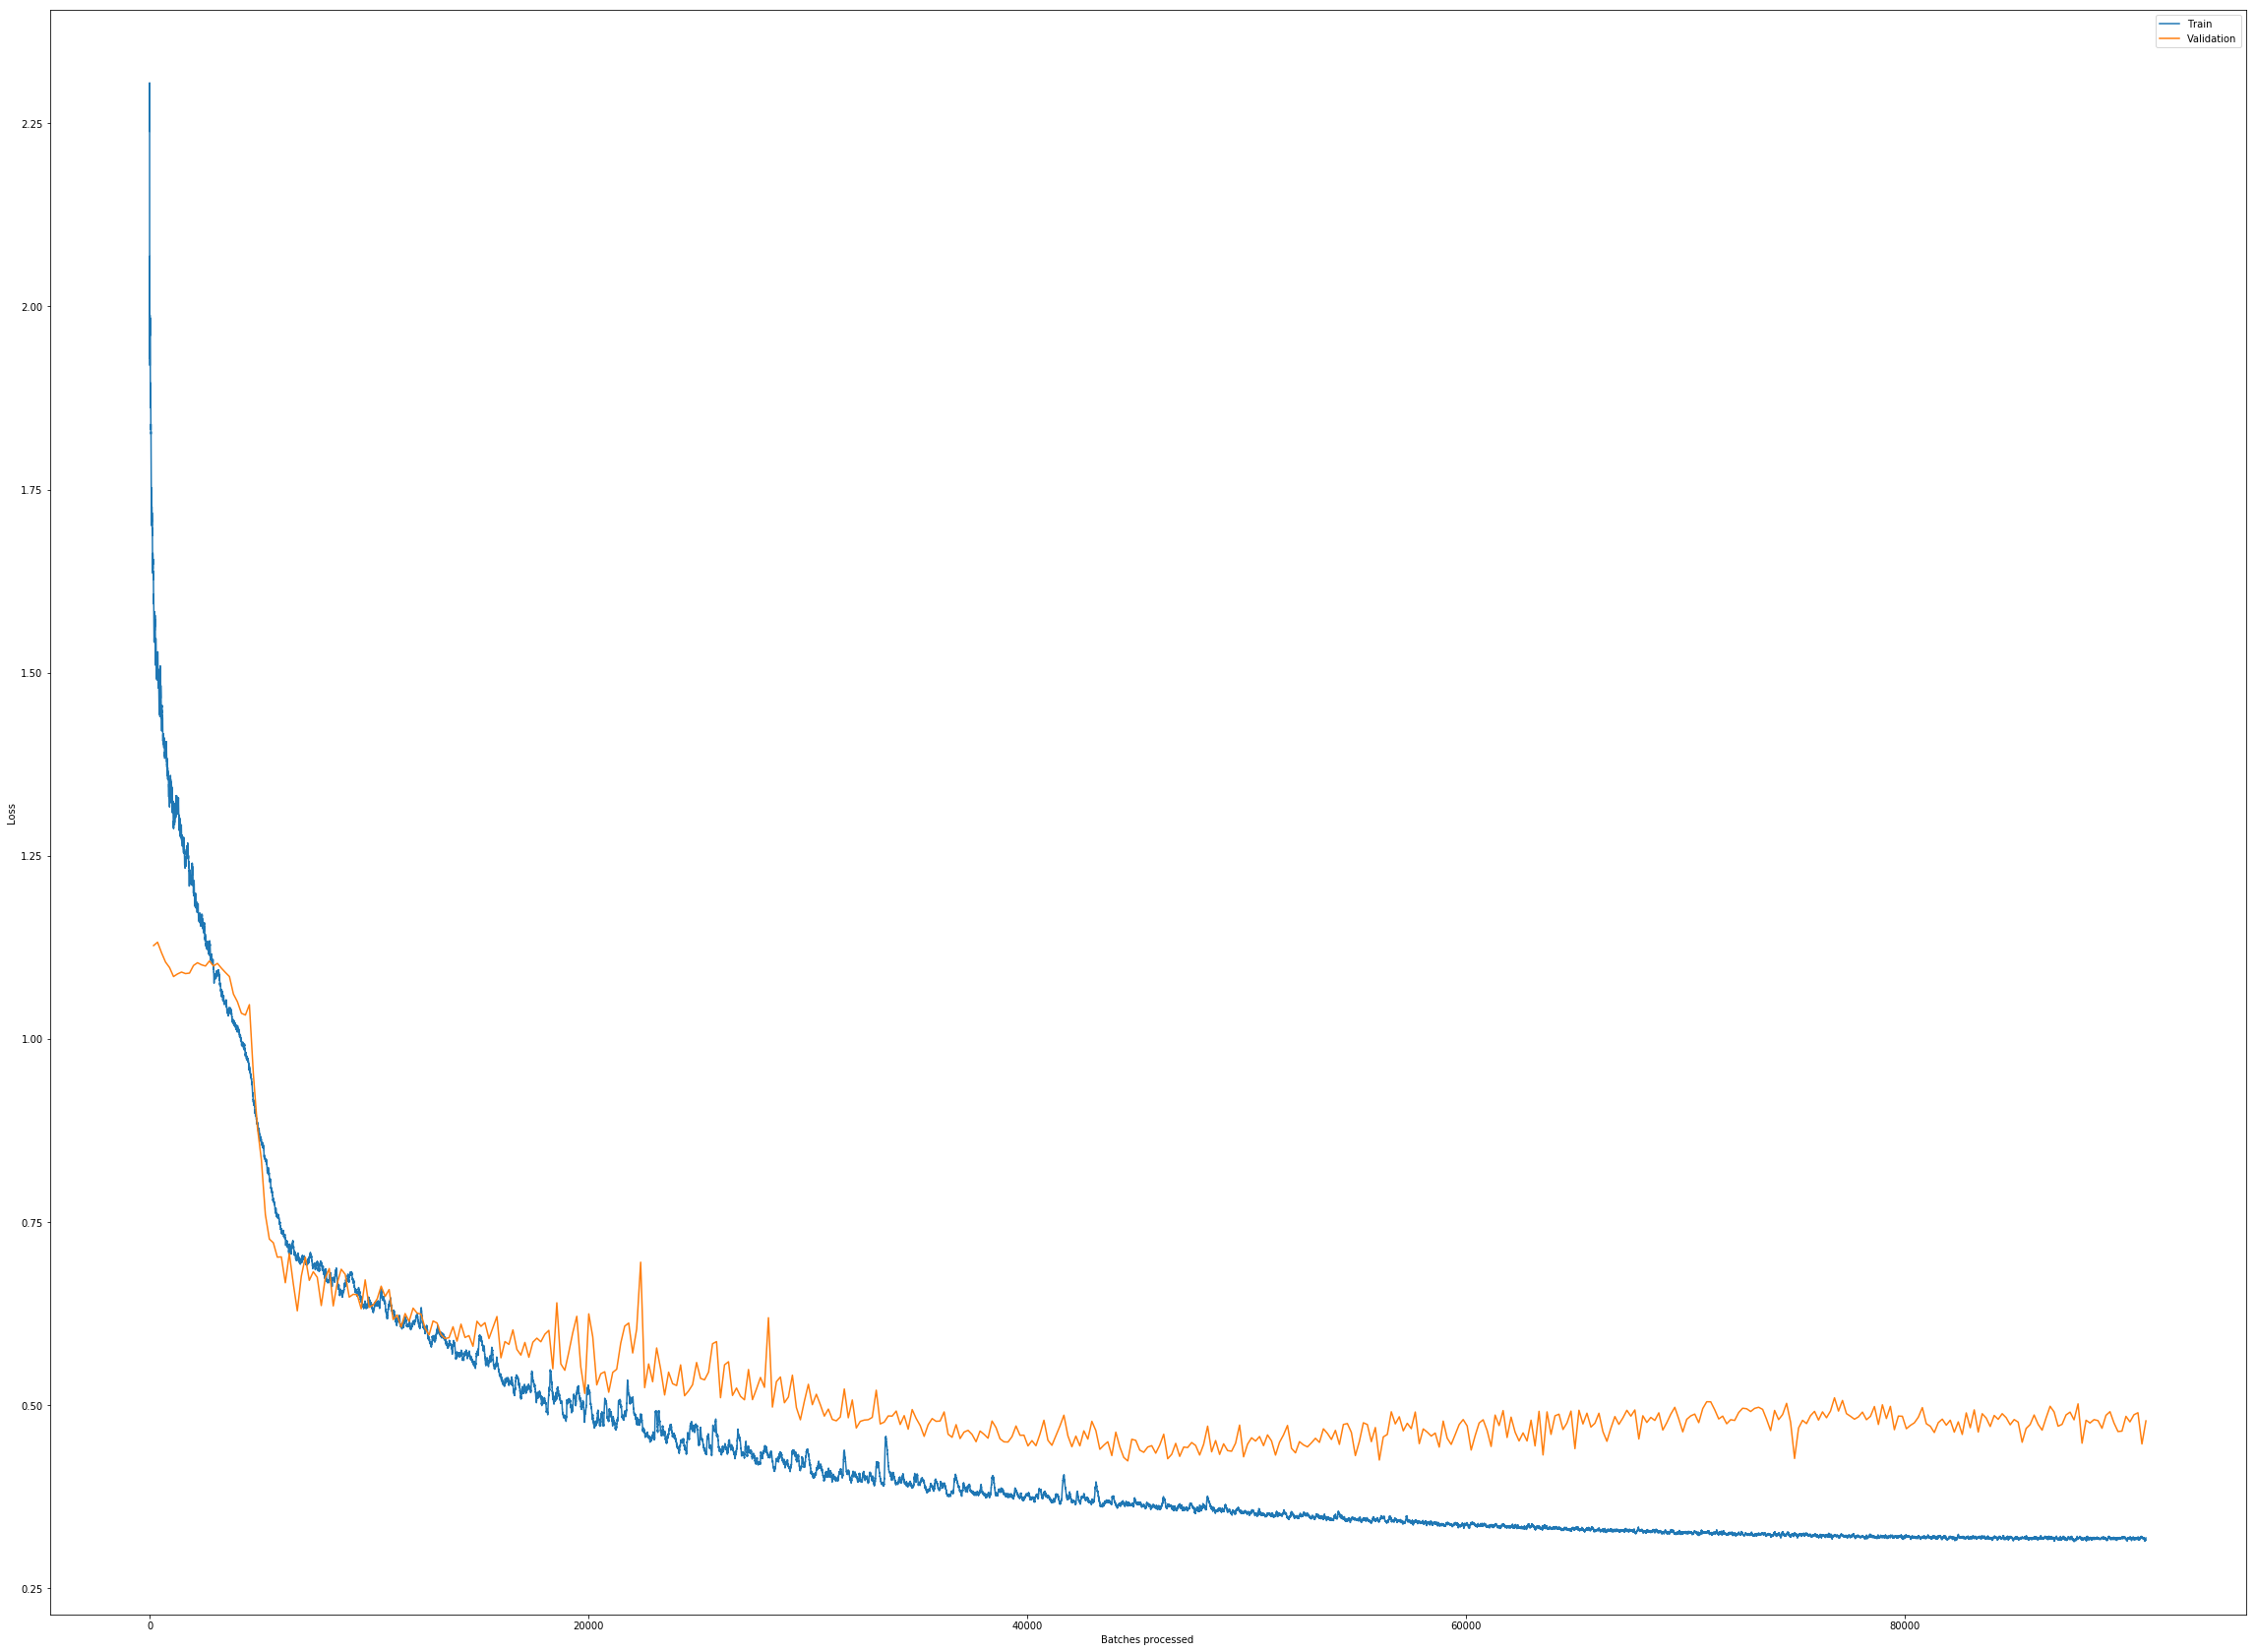

In [30]:
l.recorder.plot_losses()

In [151]:
l.save(f"speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}")

In [31]:
val_df = get_results_df(val_dl, l.model, log=log)
train_df = get_results_df(train_dl, l.model, log=log)

In [32]:
df = train_df

In [33]:
df[:][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,185651.000000,185651.000000,185651.000000,185651.000000
mean,0.929807,1.184810,0.517900,77.809196
std,1.066149,1.613917,0.832512,130.065918
min,0.056593,0.008491,0.000005,0.000762
25%,0.257230,0.211613,0.082616,22.188327
50%,0.484837,0.565550,0.217735,42.749226
75%,1.122400,1.394052,0.548610,71.472095
max,5.595907,16.089287,15.573606,3143.892822


In [156]:
df[:][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,185651.000000,185651.000000,185651.000000,185651.000000
mean,1.084814,1.184810,0.324954,40.820557
std,1.344096,1.613917,0.569854,58.587891
min,0.013156,0.008491,0.000002,0.000193
25%,0.240377,0.211613,0.042083,10.870382
50%,0.544192,0.565550,0.132497,24.538118
75%,1.470753,1.394052,0.346775,46.853222
max,7.660851,16.089287,15.755830,2158.676758


In [23]:
df[(df.interchange == 0) & (df.tile == 0) & (df.unroll == 1)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,657.000000,657.000000,657.000000,657.000000
mean,3.948848,5.115778,1.365126,29.287535
std,1.486039,2.790569,1.714994,38.937504
min,0.398863,0.105179,0.003013,0.206864
25%,2.479949,2.706949,0.270402,8.261179
50%,4.648192,5.420588,0.649103,21.397005
75%,4.834735,6.326712,1.784681,33.637047
max,5.690990,12.500638,7.442226,280.300598


/data/scratch/henni-mohammed/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


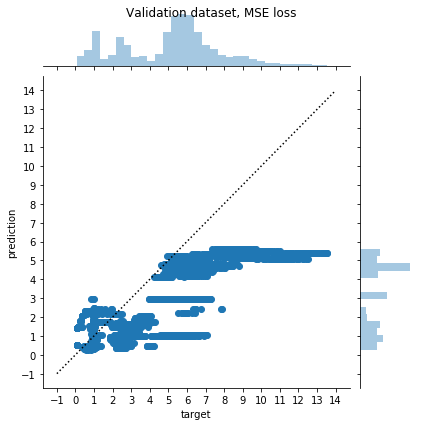

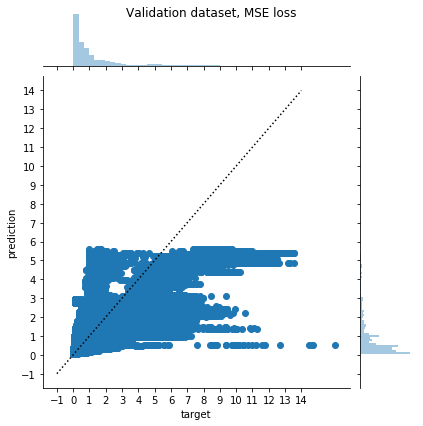

In [34]:
df1 = df[(df.interchange == 0) & (df.tile == 0) & (df.unroll == 1)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df2 = df
joint_plot(df2, f"Validation dataset, {loss_func} loss")

In [39]:
index= 128

In [40]:
train_dl.dataset.schedules[index].binary_repr

(0, 1, 1)

In [43]:
train_dl.dataset[index][0][370:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)